In [ ]:
# Импорты
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

# Путь к датасету
BASE_DIR = "/Users/timataskin/Desktop/AI-ML/Lab1"
DATA_PATH = os.path.join(BASE_DIR, "SkillCraft_no_outliers.csv")  # prefer cleaned no-outliers
if not os.path.exists(DATA_PATH):
    DATA_PATH = os.path.join(BASE_DIR, "SkillCraft_processed.csv")
if not os.path.exists(DATA_PATH):
    DATA_PATH = os.path.join(BASE_DIR, "SkillCraft.csv")  # fallback

print("Using:", DATA_PATH)


Using: /Users/timataskin/Desktop/AI-ML/Lab1/SkillCraft_no_outliers.csv


In [9]:
df = pd.read_csv(DATA_PATH)
df.shape

(2999, 20)

In [ ]:
#Объявляем target и список признаков, возьмем те же наборы, что и в ЛР1
target_col = "APM"

# x_features: основной список
features = ["HoursPerWeek", "TotalHours", "ActionLatency", "WorkersMade", "UniqueUnitsMade", "ComplexUnitsMade"]

# Оставляем только те, что есть
features = [c for c in features if c in df.columns]
print("Will use features:", features)
print("Target:", target_col)

# Оставляем в df только нужные столбцы
df = df[features + [target_col]].copy()
df.head()

Will use features: ['HoursPerWeek', 'TotalHours', 'ActionLatency', 'WorkersMade', 'UniqueUnitsMade', 'ComplexUnitsMade']
Target: APM


,HoursPerWeek,TotalHours,ActionLatency,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,APM
0,10,200,75.3548,0.000745,6,0.0,69.9612
1,20,400,53.7352,0.000426,7,0.0,107.6016
2,10,500,62.0813,0.001174,4,0.0,122.8908
3,6,70,98.7719,0.000372,6,0.0,44.4570
4,8,240,90.5311,0.000573,5,0.0,46.9962


Target mean: 113.064 Tarhet_std: 42.348


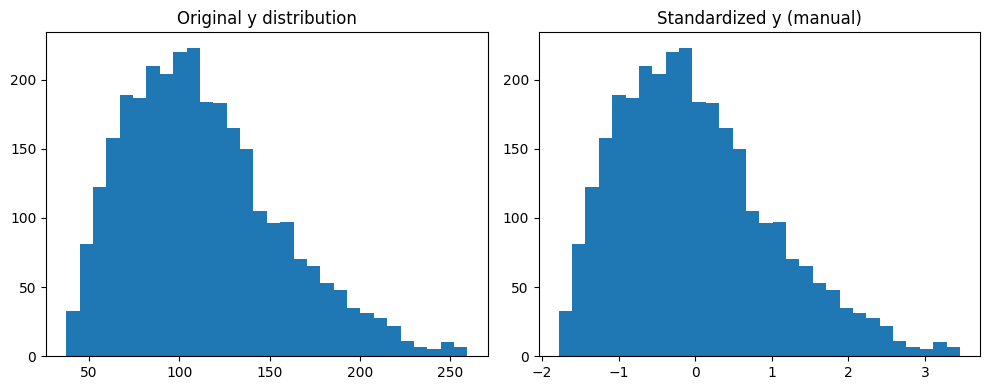

In [11]:
# Стандартизируем, создаем df_scaled
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df[features])

# среднее и std для целевой переменной
y_mean = df[target_col].mean()
y_std = df[target_col].std()
print("Target mean:", round(y_mean, 3), "Tarhet_std:", round(y_std, 3))

# гистограммы: исходной и целевой(стандартизированной)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df[target_col], bins=30)
plt.title("Original y distribution")
plt.subplot(1,2,2)
plt.hist((df[target_col] - y_mean)/y_std, bins=30)
plt.title("Standardized y (manual)")
plt.tight_layout()
plt.show()

In [ ]:
# Подготовка функции для разделения, чтобы менять seed
def make_splits(df_X, df_y, seed=0, test_size=0.2):
    return train_test_split(df_X, df_y, test_size=test_size, random_state=seed)

# выбираем seed - сперва 0, потом меняем
seed1 = 0

In [13]:
# НЕ стандартизованная выборка
X = df[features]
y = df[target_col]

X_train, X_test, y_train, y_test = make_splits(X, y, seed=seed1)
print("Sizes (not scaled) X_train/X_test:", X_train.shape, X_test.shape)

Sizes (not scaled) X_train/X_test: (2399, 6) (600, 6)


In [14]:
# стандартизованная выборка, используем ds_scaled
Xs = df_scaled[features]
ys = df_scaled[target_col] if target_col in df_scaled.columns else y # y мы не стандартизировали в df_scaled
#обычно стандартят только X
XStd_train, XStd_test, yStd_train, yStd_test = make_splits(Xs, y, seed=seed1)
print("Sizes (scaled) XStd_train/XStd_test:", XStd_train.shape, XStd_test.shape)

Sizes (scaled) XStd_train/XStd_test: (2399, 6) (600, 6)


In [18]:
# Функция обучения SGDRegressor и возвращаем метрики + preds
def train_and_eval_sgd(X_tr, y_tr, X_te, y_te, max_iter=1000, random_state=0):
    model = SGDRegressor(max_iter=max_iter, tol=1e-3, random_state=random_state)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    r2 = r2_score(y_te, y_pred)
    
    # Универсальное вычисление RMSE
    try:
        rmse = mean_squared_error(y_te, y_pred, squared=False)
    except TypeError:
        # Если squared не поддерживается
        mse = mean_squared_error(y_te, y_pred)
        rmse = np.sqrt(mse)
    
    return model, y_pred, r2, rmse

In [19]:
# Обучаем модели
m1, pred1, r2_1, rmse_1 = train_and_eval_sgd(X_train, y_train, X_test, y_test, random_state=seed1)
m2, pred2, r2_2, rmse_2 = train_and_eval_sgd(XStd_train, yStd_train, XStd_test, yStd_test, random_state=seed1)

print("m1 (not scaled) R2:", round(r2_1,4), "RMSE:", round(rmse_1,4))
print("m2 (scaled)     R2:", round(r2_2,4), "RMSE:", round(rmse_2,4))

m1 (not scaled) R2: -1.442335263088984e+25 RMSE: 150706909521386.47
m2 (scaled)     R2: 0.6005 RMSE: 25.0805


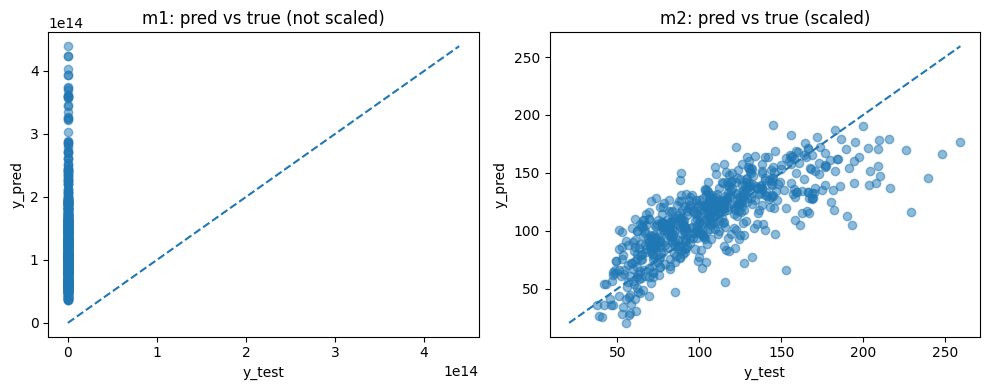

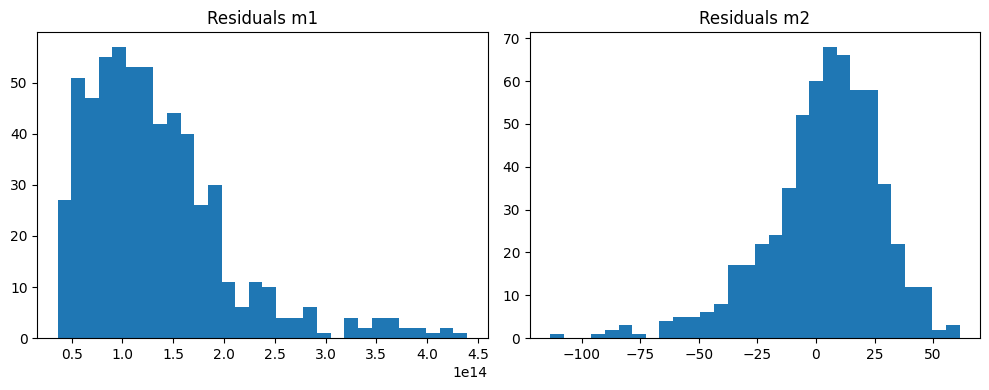

In [20]:
# scatter pred vs true for both models
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(y_test, pred1, alpha=0.5)
mn, mx = min(y_test.min(), pred1.min()), max(y_test.max(), pred1.max())
plt.plot([mn,mx], [mn,mx], '--')
plt.title("m1: pred vs true (not scaled)")
plt.xlabel("y_test"); plt.ylabel("y_pred")

plt.subplot(1,2,2)
plt.scatter(yStd_test, pred2, alpha=0.5)
mn, mx = min(yStd_test.min(), pred2.min()), max(yStd_test.max(), pred2.max())
plt.plot([mn,mx],[mn,mx],'--')
plt.title("m2: pred vs true (scaled)")
plt.xlabel("y_test"); plt.ylabel("y_pred")
plt.tight_layout()
plt.show()

# histograms of residuals
res1 = pred1 - y_test
res2 = pred2 - yStd_test

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(res1, bins=30)
plt.title("Residuals m1")
plt.subplot(1,2,2)
plt.hist(res2, bins=30)
plt.title("Residuals m2")
plt.tight_layout()
plt.show()

In [21]:
# повторяем для другого seed, к примеру seed2 = 42
seed2 = 42

X_train2, X_test2, y_train2, y_test2 = make_splits(X, y, seed=seed2)
XStd_train2, XStd_test2, yStd_train2, yStd_test2 = make_splits(Xs, y, seed=seed2)

m1b, pred1b, r2_1b, rmse_1b = train_and_eval_sgd(X_train2, y_train2, X_test2, y_test2, random_state=seed2)
m2b, pred2b, r2_2b, rmse_2b = train_and_eval_sgd(XStd_train2, yStd_train2, XStd_test2, yStd_test2, random_state=seed2)

print("Seed", seed2, "-> m1 R2:", round(r2_1b,4), "RMSE:", round(rmse_1b,4))
print("Seed", seed2, "-> m2 R2:", round(r2_2b,4), "RMSE:", round(rmse_2b,4))


Seed 42 -> m1 R2: -2.1659367153774692e+23 RMSE: 19684405742946.105
Seed 42 -> m2 R2: 0.6142 RMSE: 26.2705


In [22]:
# Кросс-валидация — используем KFold на НЕ стандартизованных и стандартизованных данных
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=0)

# Для R2 используем cross_val_score (скоро надо перевести на cv predict для RMSE)
# For R2:
model_cv = SGDRegressor(max_iter=1000, tol=1e-3, random_state=0)

r2_scores_not_scaled = cross_val_score(model_cv, X, y, scoring="r2", cv=kf)
# For RMSE, use negative MSE -> sqrt
neg_mse_scores_not_scaled = cross_val_score(model_cv, X, y, scoring="neg_mean_squared_error", cv=kf)
rmse_scores_not_scaled = np.sqrt(-neg_mse_scores_not_scaled)

# For scaled Xs
r2_scores_scaled = cross_val_score(model_cv, Xs, y, scoring="r2", cv=kf)
neg_mse_scores_scaled = cross_val_score(model_cv, Xs, y, scoring="neg_mean_squared_error", cv=kf)
rmse_scores_scaled = np.sqrt(-neg_mse_scores_scaled)

print("k =", k)
print("R2 not scaled:", np.round(r2_scores_not_scaled,4))
print("R2 scaled    :", np.round(r2_scores_scaled,4))
print("R2 mean not scaled:", round(r2_scores_not_scaled.mean(),4))
print("R2 mean scaled    :", round(r2_scores_scaled.mean(),4))

print("RMSE not scaled:", np.round(rmse_scores_not_scaled,4))
print("RMSE scaled    :", np.round(rmse_scores_scaled,4))
print("RMSE mean not scaled:", round(rmse_scores_not_scaled.mean(),4))
print("RMSE mean scaled    :", round(rmse_scores_scaled.mean(),4))


k = 5
R2 not scaled: [-1.42538637e+21 -3.08506654e+25 -3.46418684e+24 -4.09064518e+24
 -8.06277646e+23]
R2 scaled    : [0.5996 0.6    0.5739 0.5461 0.6086]
R2 mean not scaled: -7.842640092214176e+24
R2 mean scaled    : 0.5857
RMSE not scaled: [1.49818814e+12 2.31553189e+14 7.96159967e+13 8.98427261e+13
 3.81491679e+13]
RMSE scaled    : [25.109  26.3651 27.9213 29.9272 26.5798]
RMSE mean not scaled: 88131853645125.03
RMSE mean scaled    : 27.1805
